# Laplace equation

In [2]:
%%writefile hello.cu

#include <stdio.h>
#include <math.h>

const int N = 100;
const int maxIter = 1000;

// GPU kernel

__device__ int getGlobalIdx() {
   int globalIdx = threadIdx.x + threadIdx.y * blockDim.x 
                    + threadIdx.z * blockDim.x * blockDim.y;

    globalIdx += (blockIdx.x + blockIdx.y * gridDim.x + 
                  blockIdx.z * gridDim.x * gridDim.y) * 
                  blockDim.x * blockDim.y * blockDim.z;

    return globalIdx;
} 

__global__ void Iteration(double * d_a, double* d_res) {
    
    int globalIdx = getGlobalIdx();
    if (globalIdx<(N-2)*(N-2)){
    int Idx = globalIdx+N+1+(globalIdx/(N-2))*2;

                                         
    d_res[Idx] = 0.25*(d_a[Idx-1]+d_a[Idx+1]+d_a[Idx-N]+d_a[Idx+N]);

    __syncthreads();
    d_a[Idx] = 0.25*(d_res[Idx-1]+d_res[Idx+1]+d_res[Idx-N]+d_res[Idx+N]);
  __syncthreads();
    }                                     
                                                   
}

__host__ void init_matrix(double * matrix){
    for (int i = 0; i<N; i++){
      for (int j =0; j<N;j++){
        if (i==N-1){
          matrix[N*i+j] = 1;
        }
        else{
        matrix[N*i+j] = 0;
        }
      }
    }
}

int main() {
    printf("This is done on CPU\n");
    FILE *fp;
    fp = fopen("result.txt", "w");
    double *h_a = (double *) malloc(sizeof(double)* N * N);
    double *h_res = (double *) malloc(sizeof(double)* N * N);

    double *d_a;
    double *d_res;
    cudaMalloc(&d_a, sizeof(double) * N * N);
    cudaMalloc(&d_res, sizeof(double) * N * N);
    init_matrix(h_a);
    init_matrix(h_res);
    cudaMemcpy(d_a, h_a, sizeof(double)*N*N, cudaMemcpyHostToDevice);
    cudaMemcpy(d_res, h_res, sizeof(double)*N*N, cudaMemcpyHostToDevice);

    // launch GPU kernel on certain amount of threads

    for (int count=0; count<maxIter;count++){
      Iteration<<<dim3(N-2, 1, 1), dim3(N-2, 1, 1)>>>(d_a, d_res);
          cudaDeviceSynchronize();
      
    }   
    cudaDeviceSynchronize();
    cudaMemcpy(h_a, d_res, sizeof(double)*N*N, cudaMemcpyDeviceToHost);
    for (int i =0; i< N*N;i++){
        fprintf(fp, "%f\t", h_a[i]);
    }
    fprintf(fp, "\n");
    fclose(fp);
    free(h_a);
    free(h_res);
    cudaFree(d_a);
    cudaFree(d_res);

    return 0;
}

Overwriting hello.cu


In [3]:
!nvcc hello.cu -o test

In [4]:
!./test

This is done on CPU


In [5]:
with open('result.txt', 'r') as f:
  line = f.readlines()

In [6]:
import numpy as np
N = 100
data = np.array([float(i) for i in line[0].split()]).reshape(N, N)

In [7]:
import matplotlib.pyplot as plt

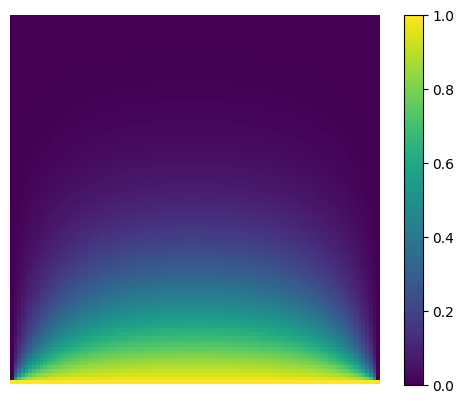

In [10]:
plt.imshow(data)
plt.colorbar()
plt.axis('off');

# Image Filtering

In [3]:
!git clone https://github.com/nothings/stb.git
!sudo cp stb/stb_image.h /usr/local/include/
!sudo cp stb/stb_image_write.h /usr/local/include

Cloning into 'stb'...
remote: Enumerating objects: 7942, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 7942 (delta 40), reused 50 (delta 32), pack-reused 7868
Receiving objects: 100% (7942/7942), 5.43 MiB | 5.97 MiB/s, done.
Resolving deltas: 100% (5265/5265), done.


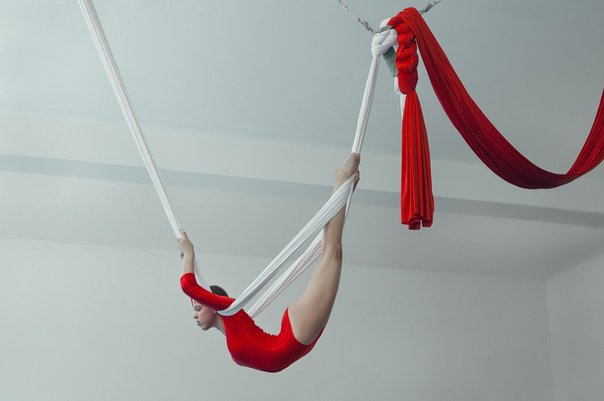

In [88]:
from PIL import Image
im = Image.open(r"file.jpeg") 
im.show()

# Bluring

In [105]:
%%writefile hello.cu
//bluring filter
#include <stdio.h>
#include <math.h>
#include <iostream>
#include <stdint.h>
#define STB_IMAGE_IMPLEMENTATION
#include "stb_image.h"
#define STBI_MSC_SECURE_CRT
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb_image_write.h"
using namespace std;

// GPU kernel

__device__ int getGlobalIdx() {
   int globalIdx = threadIdx.x + threadIdx.y * blockDim.x 
                    + threadIdx.
                    z * blockDim.x * blockDim.y;

    globalIdx += (blockIdx.x + blockIdx.y * gridDim.x + 
                  blockIdx.z * gridDim.x * gridDim.y) * 
                  blockDim.x * blockDim.y * blockDim.z;

    return globalIdx;
} 

__global__ void Convolve(uint8_t * image_d, uint8_t * d_res,  double* kernel_d, int width, int height, int res_width, int res_height, int channel, int k) {
    
    int globalIdx = getGlobalIdx();
    int row = globalIdx/width;
    int col = globalIdx%(width);
    if (globalIdx<(res_width*res_height)){
      int res_idx = row*width + col;
      int old_idx = row*width*3+col*3+channel+((k-1)/2)*width*3+((k-1)/2)*3+(globalIdx/(width-k+1))*(k-1)*3;
      double val(0);
    for (int i = 0; i<k; i++){
      for (int j =0; j<k;j++){
        val+= (double)image_d[old_idx-((k-1)/2-j)*3-((k-1)/2-i)*width*3]*kernel_d[i*k+j];
      }

    }
    d_res[res_idx] = (uint8_t)val;
    }                                                                                     
}
__host__ void initKernel (double *matrix, int k) {
  double sum = 0;
  // compute values
    for (int row = 0; row < k; row++){
      for (int col = 0; col < k; col++) {
        matrix[row*k + col] = 1;
        sum ++;
      }
    }
  // normalize
  for (int row = 0; row <k; row++){
    for (int col = 0; col < k; col++){
      matrix[row*k+col] /= sum;
    }
    }
}


int main() {
  	int width, height, ch, size;
    printf("This is done on CPU\n");
	  uint8_t* h_image = stbi_load("file.jpeg", &width, &height, &ch, 3);	
  	size = height * width * 3;
    uint8_t *image_d, *d_res, *h_res;
    FILE *fp;

    int k(7);
    cout << "kernel size (odd)"<< endl;
    cin >> k;
    int res_width = width-k+1;
    int res_height= height-k+1;
    cout << "width: "<< width << "height: "<< height<< "ch: "<<ch << "size: "<< size << "output size: "<< res_width*res_height << endl;
    cudaMalloc(&image_d, sizeof(uint8_t) * size);
    cudaMalloc(&d_res, sizeof(uint8_t) * res_width*res_height);
    h_res = (uint8_t*)malloc(sizeof(uint8_t)*res_width*res_height);
    cudaMemcpy(image_d, h_image, sizeof(uint8_t)*size, cudaMemcpyHostToDevice);
    fp = fopen("result.txt", "w+");
    double *kernel_d, *kernel_h;
    kernel_h = (double*)malloc(k*k*sizeof(double));
    initKernel(kernel_h, k);
    
    cudaMalloc(&kernel_d, sizeof(double) * k*k);
    cudaMemcpy(kernel_d, kernel_h, sizeof(double)*k*k, cudaMemcpyHostToDevice);
    for (int i = 0; i<3; i++){
      Convolve<<<dim3(res_width, 1, 1), dim3(res_height, 1, 1)>>>(image_d, d_res, kernel_d, width, height, res_width, res_height, i, k);
      cudaDeviceSynchronize();
      cudaMemcpy(h_res, d_res, sizeof(uint8_t)*res_width*res_height, cudaMemcpyDeviceToHost);

      for (int i =0; i< res_width*res_height;i++){
          fprintf(fp, "%d\t", h_res[i]);
        }

    }
   // stbi_write_png("changed_file.png", width, height, 3, h_res, width * 3);
    fclose(fp);
    cudaFree(kernel_d);
    cudaFree(image_d);
    cudaFree(d_res);
    free(kernel_h);
    free(h_image);
    return 0;
}

Overwriting hello.cu


In [106]:
!nvcc hello.cu -o test

In [107]:
!./test

This is done on CPU
kernel size (odd)
7
width: 604height: 401ch: 3size: 726612output size: 236210


In [108]:
with open('result.txt', 'r') as f:
  line = f.readlines()

In [109]:
import numpy as np
data = np.array([int(i) for i in line[0].split()])

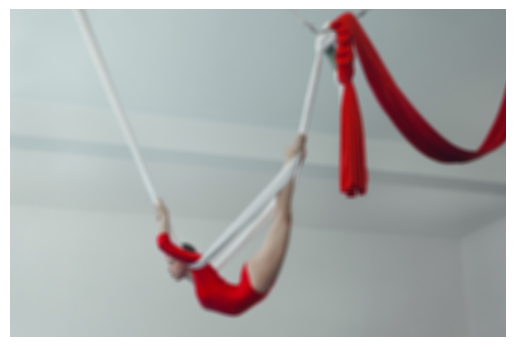

In [111]:
import matplotlib.pyplot as plt
k = 7
plt.imshow(np.moveaxis(data.reshape(3, 401-k+1, 604-k+1), [0, 1, 2], [-1, 0, 1]))
plt.axis('off');

# Median Filter

In [112]:
%%writefile hello.cu
//bluring filter
#include <stdio.h>
#include <math.h>
#include <iostream>
#include <stdint.h>
#define STB_IMAGE_IMPLEMENTATION
#include "stb_image.h"
#define STBI_MSC_SECURE_CRT
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb_image_write.h"
using namespace std;

// GPU kernel

__device__ int getGlobalIdx() {
   int globalIdx = threadIdx.x + threadIdx.y * blockDim.x 
                    + threadIdx.
                    z * blockDim.x * blockDim.y;

    globalIdx += (blockIdx.x + blockIdx.y * gridDim.x + 
                  blockIdx.z * gridDim.x * gridDim.y) * 
                  blockDim.x * blockDim.y * blockDim.z;

    return globalIdx;
} 

__global__ void Convolve(uint8_t * image_d, uint8_t * d_res, int width, int height, int res_width, int res_height, int channel, int k) {
    
    int globalIdx = getGlobalIdx();
    int row = globalIdx/width;
    int col = globalIdx%(width);
    uint8_t val[15*15];
    if (globalIdx<(res_width*res_height)){
      int res_idx = row*width + col;
      int old_idx = row*width*3+col*3+channel+((k-1)/2)*width*3+((k-1)/2)*3+(globalIdx/(width-k+1))*(k-1)*3;
      
      for (int i = 0; i<k; i++){
        for (int j =0; j<k;j++){
          val[k*i+j]=image_d[old_idx-((k-1)/2-j)*3-((k-1)/2-i)*width*3];
            }
      }
      int median(0);
      for (int i =0;i<k*k;i++){
        int tr=0;
        int trim = 0;
        int sample = val[i];
        for(int j=0;j<k*k;j++){
            if(val[j]<sample){
              tr++;
              trim++;
            }
            if (val[j]==sample){
              trim++;
            }
        }
        if (tr<(k*k-1)/2&&trim>=(k*k-1)/2){
          median=sample;
        }
      }
      d_res[res_idx] = median;

   //   printf("gid = %d  tx = %d  ty = %d  tz = %d idx = %d, d_a = %f, d_res = %f\n", globalIdx, threadIdx.x, 
   //                                              threadIdx.y, threadIdx.z, Idx, d_a[Idx], d_res[Idx]);
    }                                     
                                                   
}

int main() {
  	int width, height, ch, size;
    printf("This is done on CPU\n");
	  uint8_t* h_image = stbi_load("file.jpeg", &width, &height, &ch, 3);	
  	size = height * width * 3;
    uint8_t *image_d, *d_res, *h_res;
    
    FILE *fp;
    int k(11);
    cout << "kernel size (odd)"<< endl;
    cin >> k;
    cout << "width: "<< width << "height: "<< height<< "ch: "<<ch << "size: "<< size << "output size: "<< (width-k+1)*(height-k+1) << endl;
    cudaMalloc(&image_d, sizeof(uint8_t) * size);
    cudaMalloc(&d_res, sizeof(uint8_t) * (width-k+1)*(height-k+1));
    h_res = (uint8_t*)malloc(sizeof(uint8_t)*(width-k+1)*(height-k+1));
    cudaMemcpy(image_d, h_image, sizeof(uint8_t)*size, cudaMemcpyHostToDevice);
    fp = fopen("result.txt", "w+");
    for (int i = 0; i<3; i++){
      Convolve<<<dim3(width-k+1, 1, 1), dim3(height-k+1, 1, 1)>>>(image_d, d_res, width, height, width-k+1, height-k+1, i, k);
      cudaDeviceSynchronize();
      cudaMemcpy(h_res, d_res, sizeof(uint8_t)*(width-k+1)*(height-k+1), cudaMemcpyDeviceToHost);

      for (int i =0; i< (width-k+1)*(height-k+1);i++){
          fprintf(fp, "%d\t", h_res[i]);
        }
    }
    fclose(fp);
    cudaFree(image_d);
    cudaFree(d_res);
    free(h_image);
    return 0;
}

Overwriting hello.cu


In [113]:
!nvcc hello.cu -o test

In [114]:
!./test

This is done on CPU
kernel size (odd)
11
width: 604height: 401ch: 3size: 726612output size: 232254


In [115]:
with open('result.txt', 'r') as f:
  line = f.readlines()

In [116]:
import numpy as np
data = np.array([int(i) for i in line[0].split()])

(-0.5, 593.5, 390.5, -0.5)

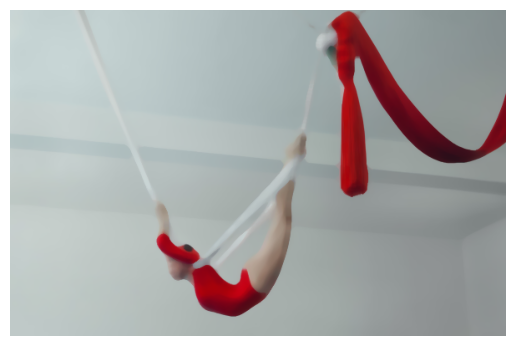

In [117]:
import matplotlib.pyplot as plt
k = 11
plt.imshow(np.moveaxis(data.reshape(3, 401-k+1, 604-k+1), [0, 1, 2], [-1, 0, 1]))
plt.axis('off')

# Histogram

In [119]:
%%writefile hello.cu
//bluring filter
#include <stdio.h>
#include <math.h>
#include <iostream>
#include <stdint.h>
#define STB_IMAGE_IMPLEMENTATION
#include "stb_image.h"
#define STBI_MSC_SECURE_CRT
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb_image_write.h"
using namespace std;

// GPU kernel

__device__ int getGlobalIdx() {
   int globalIdx = threadIdx.x + threadIdx.y * blockDim.x 
                    + threadIdx.
                    z * blockDim.x * blockDim.y;

    globalIdx += (blockIdx.x + blockIdx.y * gridDim.x + 
                  blockIdx.z * gridDim.x * gridDim.y) * 
                  blockDim.x * blockDim.y * blockDim.z;

    return globalIdx;
} 

__global__ void histogram(uint8_t * image_d, int * d_res, int width, int height) {
    
    int globalIdx = getGlobalIdx();
    if (globalIdx<(width*height)){
      int val = image_d[globalIdx];
      atomicAdd(&d_res[val], 1);
    }                                     
                                                   
}

int main() {
  	int width, height, ch, size;
    printf("This is done on CPU\n");
	  uint8_t* h_image = stbi_load("file.jpeg", &width, &height, &ch, 3);	
  	size = height * width;
    uint8_t *image_d;
    int *d_res, *h_res;

    uint8_t* gray_image = (uint8_t *)malloc(sizeof(uint8_t) * size);
    int rgb_size= 256;
    h_res = (int*)malloc(sizeof(int)*rgb_size);
    for (int i = 0; i < width; i++)
    {
      for (int j = 0; j < height; j++)
      {
        gray_image[j*width + i] = (uint8_t)((h_image[j*width*3 + i*3] + // averaging
              h_image[j*width*3 + i*3 + 1] + 
              h_image[j*width*3 + i*3 + 2]) / 3);		
      }
    }
    FILE *fp;

    cout << "width: "<< width << "height: "<< height<< "ch: "<<ch << "size: "<< size << endl;
    cudaMalloc(&image_d, sizeof(uint8_t) * size);
    cudaMalloc(&d_res, sizeof(int) *rgb_size);
    cudaMemcpy(image_d, gray_image, sizeof(uint8_t)*size, cudaMemcpyHostToDevice);
    fp = fopen("result.txt", "w+");
    histogram<<<dim3(width, 1, 1), dim3(height, 1, 1)>>>(image_d, d_res, width, height);
    cudaDeviceSynchronize();
    cudaMemcpy(h_res, d_res, sizeof(int)*rgb_size, cudaMemcpyDeviceToHost);

    for (int i =0; i< rgb_size;i++){
        fprintf(fp, "%d\t", h_res[i]);
      }
    fclose(fp);
    cudaFree(image_d);
    cudaFree(d_res);
    free(gray_image);
    free(h_res);
    free(h_image);
    return 0;
}

Overwriting hello.cu


In [120]:
!nvcc hello.cu -o test

In [121]:
!./test

This is done on CPU
width: 604height: 401ch: 3size: 242204


In [122]:
with open('result.txt', 'r') as f:
  line = f.readlines()

In [123]:
import numpy as np
data = np.array([int(i) for i in line[0].split()])

In [124]:
import matplotlib.pyplot as plt


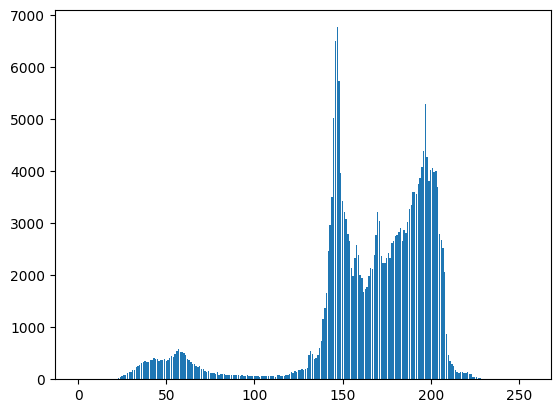

In [125]:
bins = np.arange(0, 256, 1)
plt.bar(bins, data);